# Brain Cancer Detection With Deep Learning

This project is done to **predict brain cancer** using Deep Learning. Specifically, I am using **CNN** (Convolutional Neural Network) Algorithms, a type of neural network that involves a convolutional layer, activation layer (this differs for different algorithms), and a pooling layer that retains important information. This type of algorithm is powerful for learning on images, making it a good choice to diagnose cancer or other diseases through image analysis.

For this project, I am using the following kaggle dataset: https://www.kaggle.com/datasets/masumhasan/brain-tumor-mri-dataset/. Proper citations at the end of this project.

In [1]:
import os
from glob import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
BASE_DIR = "data"  # assuming you extracted archive.zip and kept this folder name

TRAIN_DIR = os.path.join(BASE_DIR, "Training")
TEST_DIR = os.path.join(BASE_DIR, "Testing")

print("Train directory:", TRAIN_DIR)
print("Test directory:", TEST_DIR)

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test classes:", os.listdir(TEST_DIR))


Train directory: data\Training
Test directory: data\Testing
Train classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# 1: EDA

### Data
Building a Dataframe of all the images and showing tabulated data:

In [3]:
def build_metadata(split_dir, split_name):
    rows = []
    classes = sorted(os.listdir(split_dir))
    for label in classes:
        class_dir = os.path.join(split_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for filepath in glob(os.path.join(class_dir, "*")):
            if not os.path.isfile(filepath):
                continue
            rows.append({
                "filepath": filepath,
                "split": split_name,
                "label": label
            })
    return rows

train_rows = build_metadata(TRAIN_DIR, "train")
test_rows = build_metadata(TEST_DIR, "test")

meta_df = pd.DataFrame(train_rows + test_rows)
meta_df.head()


,filepath,split,label
0,data\Training\glioma\Tr-glTr_0000.jpg,train,glioma
1,data\Training\glioma\Tr-glTr_0001.jpg,train,glioma
2,data\Training\glioma\Tr-glTr_0002.jpg,train,glioma
3,data\Training\glioma\Tr-glTr_0003.jpg,train,glioma
4,data\Training\glioma\Tr-glTr_0004.jpg,train,glioma


In [4]:
print("Total images:", len(meta_df))
print("\nImages per split:")
print(meta_df["split"].value_counts())

print("\nImages per class:")
print(meta_df["label"].value_counts())


Total images: 6967

Images per split:
split
train    5724
test     1243
Name: count, dtype: int64

Images per class:
label
notumor       2000
pituitary     1769
meningioma    1645
glioma        1553
Name: count, dtype: int64


### Figures

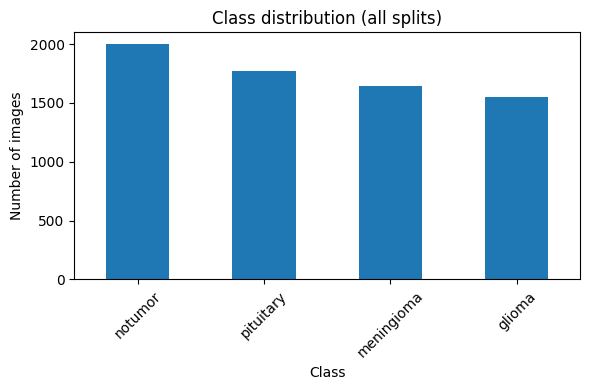

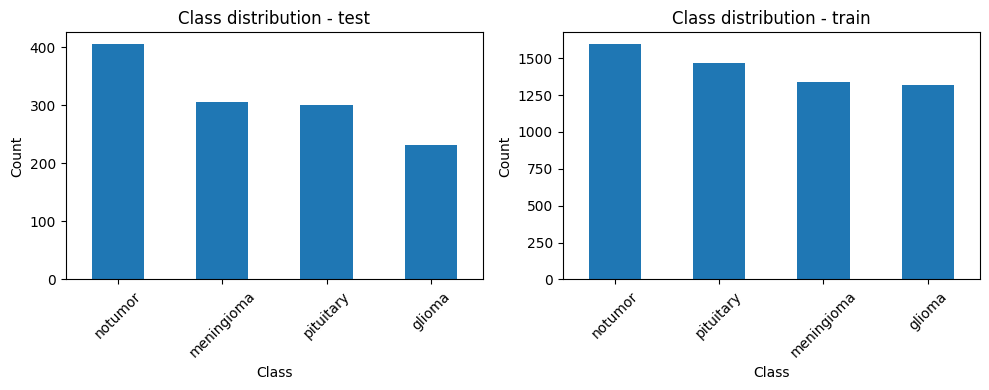

In [5]:
plt.figure(figsize=(6,4))
meta_df["label"].value_counts().plot(kind="bar")
plt.title("Class distribution (all splits)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
for i, split in enumerate(sorted(meta_df["split"].unique()), 1):
    plt.subplot(1, 2, i)
    split_counts = meta_df[meta_df["split"] == split]["label"].value_counts()
    split_counts.plot(kind="bar")
    plt.title(f"Class distribution - {split}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def get_image_stats(path, max_fail=10):
    try:
        with Image.open(path) as img:
            img_arr = np.array(img)
            h, w = img_arr.shape[:2]
            # Convert to grayscale for intensity stats (if needed)
            if img_arr.ndim == 3:
                gray = img_arr.mean(axis=2)
            else:
                gray = img_arr
            mean_intensity = gray.mean()
            std_intensity = gray.std()
        file_size_kb = os.path.getsize(path) / 1024.0
        return w, h, mean_intensity, std_intensity, file_size_kb
    except Exception as e:
        # Return NaNs if can't read
        return np.nan, np.nan, np.nan, np.nan, np.nan

sample_df = meta_df.copy()

stats = sample_df["filepath"].apply(get_image_stats)
sample_df[["width", "height", "mean_intensity", "std_intensity", "file_size_kb"]] = pd.DataFrame(stats.tolist(), index=sample_df.index)

sample_df.head()


,filepath,split,label,width,height,mean_intensity,std_intensity,file_size_kb
0,data\Training\glioma\Tr-glTr_0000.jpg,train,glioma,512,512,31.387234,43.352772,22.584961
1,data\Training\glioma\Tr-glTr_0001.jpg,train,glioma,512,512,37.844910,43.527716,23.375977
2,data\Training\glioma\Tr-glTr_0002.jpg,train,glioma,512,512,36.035866,40.893389,23.879883
3,data\Training\glioma\Tr-glTr_0003.jpg,train,glioma,512,512,24.906197,27.875719,21.722656
4,data\Training\glioma\Tr-glTr_0004.jpg,train,glioma,512,512,32.082684,33.501708,24.715820


In [7]:
print("Number of images with NaN metadata:", sample_df.isna().any(axis=1).sum())
sample_df.describe(include="all")


Number of images with NaN metadata: 0


,filepath,split,label,width,height,mean_intensity,std_intensity,file_size_kb
count,6967,6967,6967,6967.000000,6967.000000,6967.000000,6967.000000,6967.000000
unique,6967,2,4,NaN,NaN,NaN,NaN,NaN
top,data\Training\glioma\Tr-glTr_0000.jpg,train,notumor,NaN,NaN,NaN,NaN,NaN
freq,1,5724,2000,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,445.360126,447.835223,47.741357,47.584863,22.090211
std,NaN,NaN,NaN,132.725516,126.659955,18.079663,13.451338,15.894003
min,NaN,NaN,NaN,150.000000,168.000000,9.768337,20.827005,3.393555
25%,NaN,NaN,NaN,380.000000,400.000000,35.218568,39.167601,14.965820
50%,NaN,NaN,NaN,512.000000,512.000000,44.609333,43.892974,20.604492
75%,NaN,NaN,NaN,512.000000,512.000000,54.896849,50.908348,26.498047


### Image Dimensions

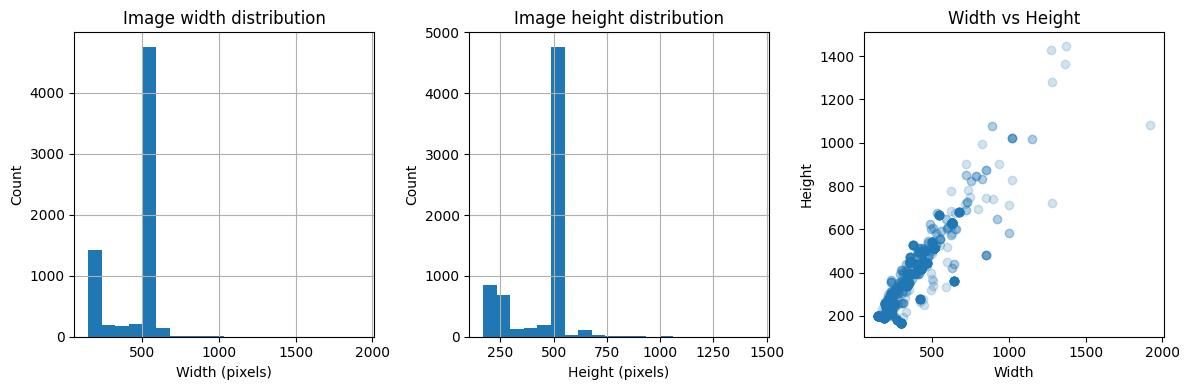

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sample_df["width"].hist(bins=20)
plt.title("Image width distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1,3,2)
sample_df["height"].hist(bins=20)
plt.title("Image height distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.subplot(1,3,3)
plt.scatter(sample_df["width"], sample_df["height"], alpha=0.2)
plt.title("Width vs Height")
plt.xlabel("Width")
plt.ylabel("Height")

plt.tight_layout()
plt.show()


### File Size and intensity distributions

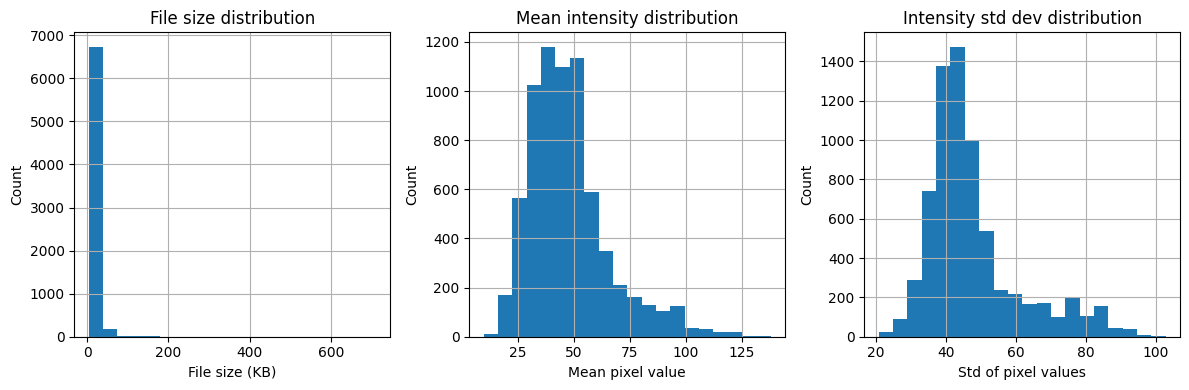

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sample_df["file_size_kb"].hist(bins=20)
plt.title("File size distribution")
plt.xlabel("File size (KB)")
plt.ylabel("Count")

plt.subplot(1,3,2)
sample_df["mean_intensity"].hist(bins=20)
plt.title("Mean intensity distribution")
plt.xlabel("Mean pixel value")
plt.ylabel("Count")

plt.subplot(1,3,3)
sample_df["std_intensity"].hist(bins=20)
plt.title("Intensity std dev distribution")
plt.xlabel("Std of pixel values")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Sample Images

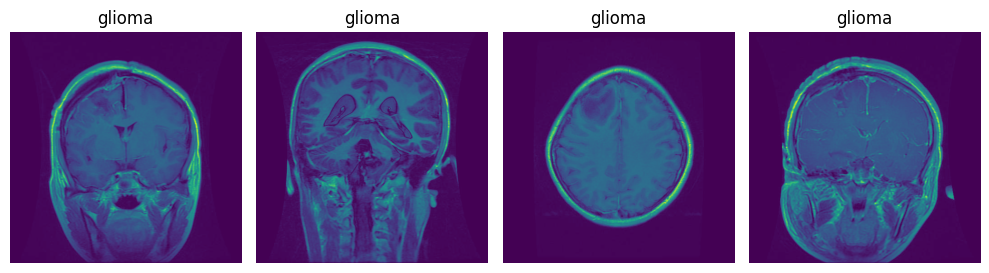

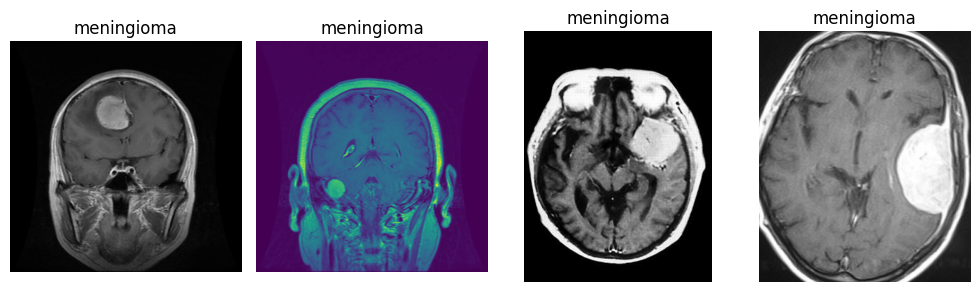

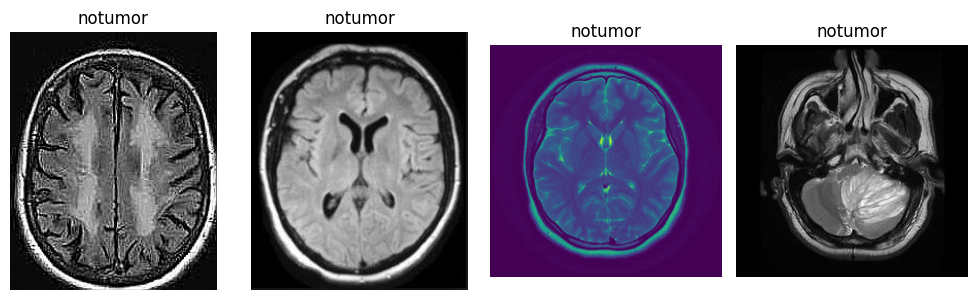

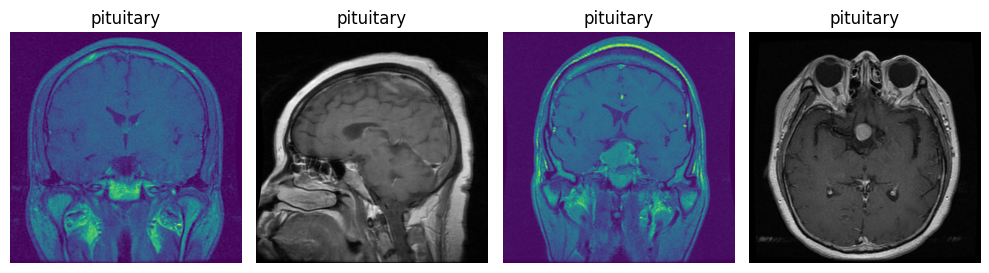

In [18]:
def show_sample_images(df, label, n=4):
    subset = df[(df["label"] == label) & (df["split"] == "train")]
    subset = subset.sample(min(n, len(subset)), random_state=42)
    plt.figure(figsize=(10,3))
    for i, (_, row) in enumerate(subset.iterrows(), 1):
        img = Image.open(row["filepath"])
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.tight_layout()
    plt.show()

for label in sorted(meta_df["label"].unique()):
    show_sample_images(meta_df, label, n=4)


### Data Cleaning

1. No NaN images found, so images do not need to be removed.
2. Use a fixed target size for model input (224×224).
3. Normalize pixel values to [0, 1] or use model-specific preprocessing (for MobileNetV2).
4. Create a validation split from the training data with keras.


In [ ]:
clean_df = meta_df.copy()
if "width" in sample_df.columns:
    bad_paths = sample_df[sample_df["width"].isna()]["filepath"].tolist()
    print(f"Number of problematic images: {len(bad_paths)}")
    if bad_paths:
        clean_df = clean_df[~clean_df["filepath"].isin(bad_paths)]

print("Remaining images after cleaning:", len(clean_df))
clean_df["split"].value_counts()


Number of problematic images: 0
Remaining images after cleaning: 6967


split
train    5724
test     1243
Name: count, dtype: int64

# 2: Architecure
I am going to make three primary models: A baseline CNN Model, a deeper model with Batch Normalization, and transfer learning with MobileNetV2.

I expect the best model to be MobileNetV2, which is considered a powerful model [\[2\]](https://www.geeksforgeeks.org/machine-learning/image-recognition-with-mobilenet/). I expect BatchNorm to be the second best, followed by the baseline model.

In [49]:
IMG_SIZE = (224, 224)  # good for transfer learning
BATCH_SIZE = 32
SEED = 42

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation generators from Training folder
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=SEED
)

# Test generator from Testing folder
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)


Found 4581 images belonging to 4 classes.
Found 1143 images belonging to 4 classes.
Found 1243 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [50]:
def build_baseline_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

input_shape = IMG_SIZE + (3,)
num_classes = len(class_indices)

baseline_cnn = build_baseline_cnn(input_shape, num_classes)
baseline_cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def build_deeper_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

deeper_cnn = build_deeper_cnn(input_shape, num_classes)
deeper_cnn.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,236,676 (50.49 MB)

 Trainable params: 13,235,716 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [52]:
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False  # start with frozen base

    inputs = layers.Input(shape=input_shape)
    x = mobilenet_preprocess(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

mobilenet_model = build_mobilenet_model(input_shape, num_classes)
mobilenet_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [47]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        verbose=1
    )
]


In [26]:
EPOCHS = 15

history_baseline = baseline_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 448ms/step - accuracy: 0.5752 - loss: 0.9959 - val_accuracy: 0.7069 - val_loss: 0.9168 - learning_rate: 0.0010
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.7201 - loss: 0.6889 - val_accuracy: 0.7218 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.7553 - loss: 0.6084 - val_accuracy: 0.6614 - val_loss: 0.8743 - learning_rate: 0.0010
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 438ms/step - accuracy: 0.7732 - loss: 0.5909 - val_accuracy: 0.7323 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 448ms/step - accuracy: 0.7893 - loss: 0.5413 - val_accuracy: 0.7489 - val_loss: 0.7265 - learning_rate: 0.0010
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.8120 - loss: 0.4819 - val_accuracy: 0.7270 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 7/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.8

In [53]:
history_deeper = deeper_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 135s 921ms/step - accuracy: 0.6147 - loss: 1.1648 - val_accuracy: 0.2310 - val_loss: 1.8570 - learning_rate: 1.0000e-04
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 142s 978ms/step - accuracy: 0.7007 - loss: 0.7454 - val_accuracy: 0.2826 - val_loss: 1.6549 - learning_rate: 1.0000e-04
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.7372 - loss: 0.6855
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
144/144 ━━━━━━━━━━━━━━━━━━━━ 128s 890ms/step - accuracy: 0.7437 - loss: 0.6623 - val_accuracy: 0.3876 - val_loss: 1.4654 - learning_rate: 1.0000e-04
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 123s 851ms/step - accuracy: 0.7677 - loss: 0.5744 - val_accuracy: 0.5713 - val_loss: 1.0613 - learning_rate: 5.0000e-05
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 813ms/step - accuracy: 0.7863 - loss: 0.5478 - val_accuracy: 0.7349 - val_loss: 0.6960 - learning_rate: 5.0000e-05
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 119s 82

In [38]:
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 51s 355ms/step - accuracy: 0.2777 - loss: 1.4729 - val_accuracy: 0.3771 - val_loss: 1.3663 - learning_rate: 5.0000e-05
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.2938 - loss: 1.4444 - val_accuracy: 0.3185 - val_loss: 1.3618 - learning_rate: 5.0000e-05
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.2911 - loss: 1.4573
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
144/144 ━━━━━━━━━━━━━━━━━━━━ 85s 594ms/step - accuracy: 0.2947 - loss: 1.4428 - val_accuracy: 0.3473 - val_loss: 1.3510 - learning_rate: 5.0000e-05
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 98s 680ms/step - accuracy: 0.3056 - loss: 1.4333 - val_accuracy: 0.3937 - val_loss: 1.3473 - learning_rate: 2.5000e-05
Epoch 5/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 54s 375ms/step - accuracy: 0.3307 - loss: 1.3948 - val_accuracy: 0.3876 - val_loss: 1.3423 - learning_rate: 2.5000e-05
Epoch 6/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/ste

This model stopped after 10 epochs because the accuracy was not increasing, as the earlyStopping patience is set to 10.

# 3: Analysis

### Evaluate Models on test set

In [60]:
baseline_test_loss, baseline_test_acc = baseline_cnn.evaluate(test_generator, verbose=0)
deeper_test_loss, deeper_test_acc = deeper_cnn.evaluate(test_generator, verbose=0)
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(test_generator, verbose=0)

print("Baseline CNN - Test accuracy:", baseline_test_acc, " Test loss:", baseline_test_loss)
print("Deeper CNN   - Test accuracy:", deeper_test_acc,    " Test loss:", deeper_test_loss)
print("MobileNetV2  - Test accuracy:", mobilenet_test_acc, " Test loss:", mobilenet_test_loss)


Baseline CNN - Test accuracy: 0.31295254826545715  Test loss: 1.3816306591033936
Deeper CNN   - Test accuracy: 0.8181818127632141  Test loss: 0.5432668328285217
MobileNetV2  - Test accuracy: 0.18664520978927612  Test loss: 1.685530424118042


### Plot History

In [55]:
def plot_history(history, title_prefix="Model"):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, "o-", label="Train acc")
    plt.plot(epochs, val_acc, "o-", label="Val acc")
    plt.title(f"{title_prefix} accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "o-", label="Train loss")
    plt.plot(epochs, val_loss, "o-", label="Val loss")
    plt.title(f"{title_prefix} loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


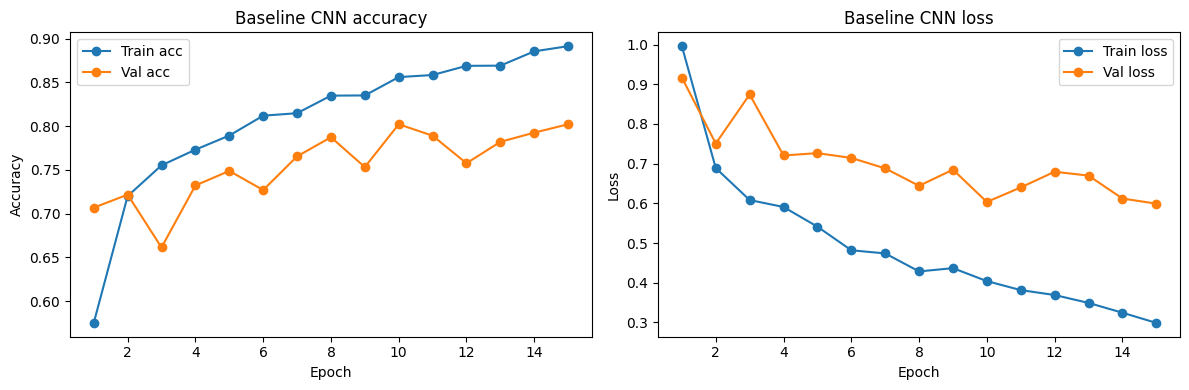

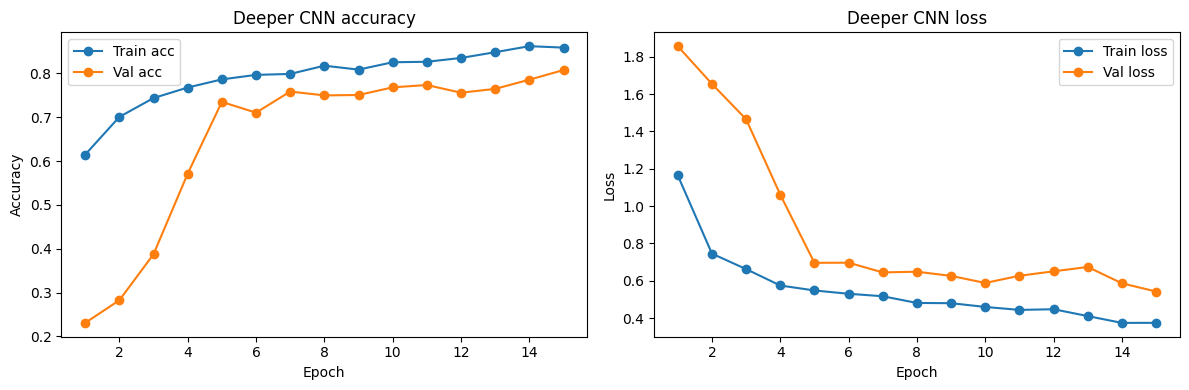

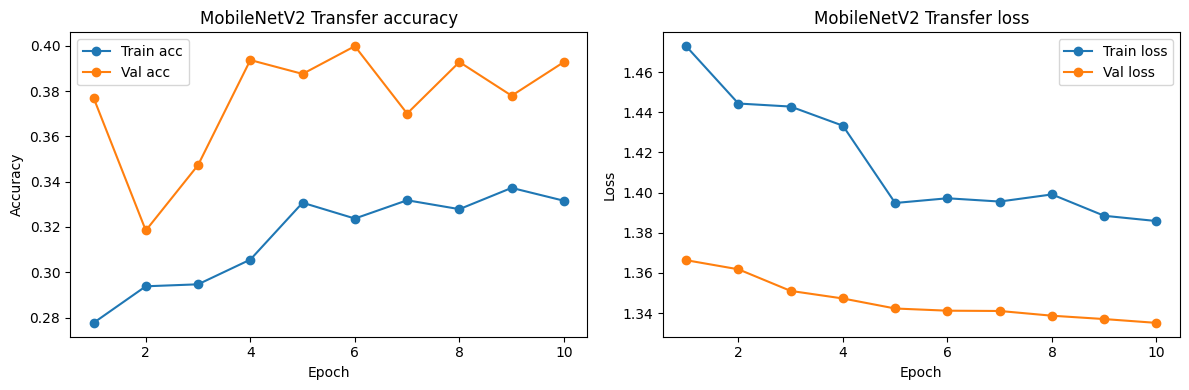

In [59]:
plot_history(history_baseline, "Baseline CNN")
plot_history(history_deeper, "Deeper CNN")
plot_history(history_mobilenet, "MobileNetV2 Transfer")


In [57]:
results = pd.DataFrame({
    "model": ["Baseline CNN", "Deeper CNN", "MobileNetV2"],
    "test_accuracy": [baseline_test_acc, deeper_test_acc, mobilenet_test_acc],
    "test_loss": [baseline_test_loss, deeper_test_loss, mobilenet_test_loss]
})

results.sort_values("test_accuracy", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results


,model,test_accuracy,test_loss
0,Deeper CNN,0.818182,0.543267
1,Baseline CNN,0.312953,1.381631
2,MobileNetV2,0.186645,1.685530


Best model: Deeper CNN
Classification report:

              precision    recall  f1-score   support

      glioma       0.78      0.90      0.83       232
  meningioma       0.92      0.35      0.51       306
     notumor       0.80      1.00      0.88       405
   pituitary       0.85      0.99      0.92       300

    accuracy                           0.82      1243
   macro avg       0.83      0.81      0.79      1243
weighted avg       0.83      0.82      0.79      1243



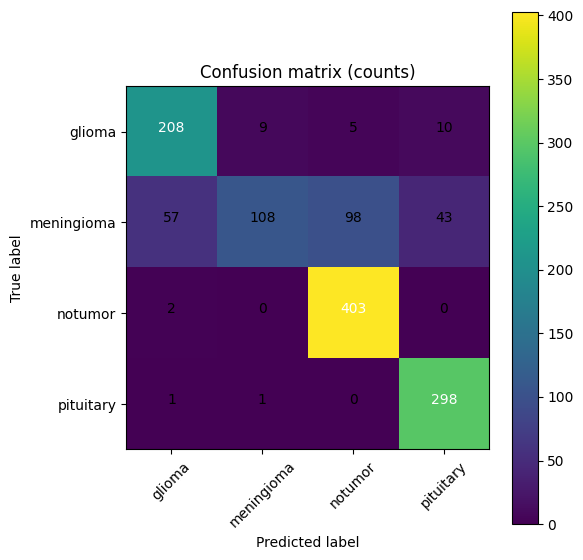

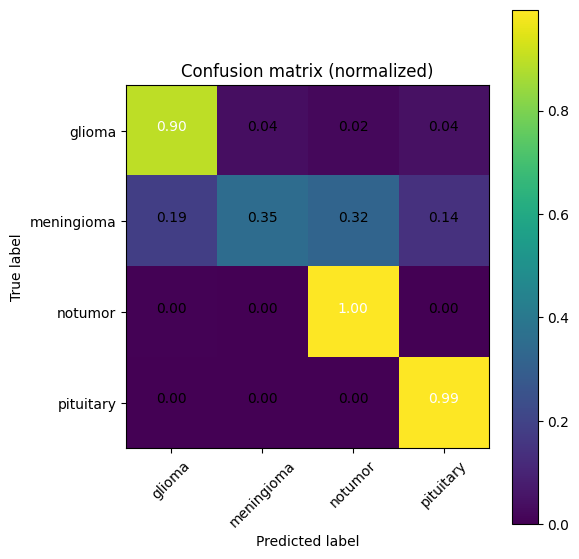

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Choose the model with highest test accuracy
best_row = results.iloc[0]
best_model_name = best_row["model"]
print("Best model:", best_model_name)

if best_model_name == "Baseline CNN":
    best_model = baseline_cnn
elif best_model_name == "Deeper CNN":
    best_model = deeper_cnn
else:
    best_model = mobilenet_model

# Predict on test set
y_true = test_generator.classes
y_prob = best_model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=list(class_indices.keys()), normalize=False,
                      title="Confusion matrix (counts)")
plot_confusion_matrix(cm, classes=list(class_indices.keys()), normalize=True,
                      title="Confusion matrix (normalized)")


## 4: Conclusion and Further Analysis

### Results

Based on the test accuracy and test loss:

- The Deeper CNN with batch normalization performss best (0.818 accuracy).
- The Baseline CNN performs worse (0.313 accuracy).
- The MobileNetV2 had the worst performance, only having an accuracy of 0.187. The results are contrary to my hypothesis.

Furthermore, we see that Meningioma is often confused with other cancers (and non-tumor images especially). 

### Further Work and Possible Improvements

- Fine-tune deeper layers of the MobileNetV2 base model after initial training.
- Use higher image resolution or multi-slice.
- Use more brain scans if possible, especially of meningioma to get more accurate results.
- Explore other architectures (e.g., EfficientNet, ResNet, DenseNet).


# References
[1] Brain Tumor MRI Dataset (November, 2025), Masumhasan. https://www.kaggle.com/datasets/masumhasan/brain-tumor-mri-dataset/

[2] MobileNet, GeeksForGeeks. https://www.geeksforgeeks.org/machine-learning/image-recognition-with-mobilenet/

[3] What is Batch Normalization, GeeksForGeeks. https://www.geeksforgeeks.org/computer-vision/what-is-batch-normalization-in-cnn/